In [1]:
import urllib.request
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding
import pandas as pd
import joblib as jb
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm



In [2]:
# Load data from crawler file
df = pd.read_csv("data - data.csv")
df.head(10)

,comment,label,rate,Unnamed: 3
0,Áo bao đẹp ạ!!,POS,5,NaN
1,Tuyệt vời !,POS,5,NaN
2,2day ao khong giong trong.,NEG,1,NaN
3,"Mùi thơm,bôi lên da mềm da.",POS,5,NaN
4,"Vải đẹp, dày dặn.",POS,5,NaN
5,"Hàng rất đẹp, rất chi là ưng ý.",POS,5,NaN
6,"Chất lượng sản phẩm tốt, date dài.",POS,5,NaN
7,Ăn nói và thái độ phục vụ tốt.,POS,4,NaN
8,Đóng gói sản phẩm chắc chắn.,POS,5,NaN
9,tất sờn hết ca chưa dùng mà vay r.,NEG,2,NaN


In [3]:
tweet_df = df[['comment','label']]
print(tweet_df.shape)
tweet_df

(31460, 2)


,comment,label
0,Áo bao đẹp ạ!!,POS
1,Tuyệt vời !,POS
2,2day ao khong giong trong.,NEG
3,"Mùi thơm,bôi lên da mềm da.",POS
4,"Vải đẹp, dày dặn.",POS
...,...,...
31455,Không đáng tiền.,NEG
31456,Quần rất đẹp.,POS
31457,Hàng đẹp đúng giá tiền.,POS
31458,Chất vải khá ổn.,POS


In [4]:
tweet_df = tweet_df[tweet_df['label'] != 'NEU']
print(tweet_df.shape)
tweet_df.head(5)

(26762, 2)


,comment,label
0,Áo bao đẹp ạ!!,POS
1,Tuyệt vời !,POS
2,2day ao khong giong trong.,NEG
3,"Mùi thơm,bôi lên da mềm da.",POS
4,"Vải đẹp, dày dặn.",POS


In [5]:
sentiment_label = tweet_df.label.factorize()
sentiment_label

(array([0, 0, 1, ..., 0, 0, 0]), Index(['POS', 'NEG'], dtype='object'))

In [6]:
def standardize_data(row):
    # Xóa dấu chấm, phẩy, hỏi ở cuối câu
    row = re.sub(r"[\.,\?]+$-", "", row)
    # Xóa tất cả dấu chấm, phẩy, chấm phẩy, chấm thang, ... trong câu
    row = row.replace(",", " ").replace(".", " ") \
        .replace(";", " ").replace("“", " ") \
        .replace(":", " ").replace("”", " ") \
        .replace('"', " ").replace("'", " ") \
        .replace("!", " ").replace("?", " ") \
        .replace("-", " ").replace("?", " ")
    row = row.strip()
    return row

In [7]:
dt = tweet_df.comment.apply(standardize_data)
dt.head()

0                  Áo bao đẹp ạ
1                     Tuyệt vời
2     2day ao khong giong trong
3    Mùi thơm bôi lên da mềm da
4              Vải đẹp  dày dặn
Name: comment, dtype: object

In [8]:
tweet = dt.values
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(tweet)
vocab_size = len(tokenizer.word_index) + 1
encoded_docs = tokenizer.texts_to_sequences(tweet)
padded_sequence = pad_sequences(encoded_docs, maxlen=200)
print(tokenizer.word_index)

{'rất': 1, 'sản': 2, 'phẩm': 3, 'đẹp': 4, 'chất': 5, 'shop': 6, 'hàng': 7, 'lượng': 8, 'giao': 9, 'tuyệt': 10, 'vời': 11, 'và': 12, 'áo': 13, 'gói': 14, 'đóng': 15, 'tốt': 16, 'nhanh': 17, 'tiền': 18, 'chắc': 19, 'chắn': 20, 'đáng': 21, 'vụ': 22, 'phục': 23, 'gian': 24, 'thời': 25, 'vải': 26, 'nhưng': 27, 'hình': 28, 'mua': 29, 'lắm': 30, 'mặc': 31, 'hơi': 32, 'mình': 33, 'màu': 34, 'ko': 35, 'giá': 36, 'có': 37, 'k': 38, 'như': 39, 'ok': 40, 'quá': 41, 'không': 42, 'mà': 43, 'thì': 44, 'là': 45, 'với': 46, 'được': 47, 'cho': 48, 'sẽ': 49, 'hộ': 50, 'luôn': 51, 'ủng': 52, 'bị': 53, 'ạ': 54, 'lại': 55, 'nên': 56, 'ưng': 57, 'tình': 58, 'giống': 59, 'quần': 60, 'nhiệt': 61, '1': 62, 'cũng': 63, 'hơn': 64, 'size': 65, 'dài': 66, 'kém': 67, 'mỏng': 68, 'lần': 69, 'nữa': 70, 'vừa': 71, 'còn': 72, 'sp': 73, 'cái': 74, 'thích': 75, 'sao': 76, 'này': 77, 'đặt': 78, 'rộng': 79, 'ý': 80, 'đc': 81, 'y': 82, 'nhận': 83, 'chủ': 84, 'đúng': 85, 'đã': 86, 'so': 87, 'của': 88, '2': 89, 'dễ': 90, 'khá'

In [9]:
embedding_vector_length = 32
model = Sequential() 
model.add(Embedding(vocab_size, embedding_vector_length, input_length=200) )
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid')) 
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])  
print(model.summary()) 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 32)           210112    
                                                                 
 spatial_dropout1d (SpatialD  (None, 200, 32)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 50)                16600     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 226,763
Trainable params: 226,763
Non-trainable params: 0
__________________________________________________

In [10]:
history = model.fit(padded_sequence,sentiment_label[0],validation_split=0.2, epochs=5, batch_size=32)

Epoch 1/5
670/670 [==============================] - 169s 248ms/step - loss: 0.3266 - accuracy: 0.8590 - val_loss: 0.2397 - val_accuracy: 0.9021
Epoch 2/5
670/670 [==============================] - 166s 248ms/step - loss: 0.2077 - accuracy: 0.9237 - val_loss: 0.2158 - val_accuracy: 0.9137
Epoch 3/5
670/670 [==============================] - 167s 249ms/step - loss: 0.1801 - accuracy: 0.9356 - val_loss: 0.2051 - val_accuracy: 0.9199
Epoch 4/5
670/670 [==============================] - 166s 248ms/step - loss: 0.1682 - accuracy: 0.9403 - val_loss: 0.2022 - val_accuracy: 0.9225
Epoch 5/5
670/670 [==============================] - 167s 249ms/step - loss: 0.1562 - accuracy: 0.9444 - val_loss: 0.2165 - val_accuracy: 0.9214


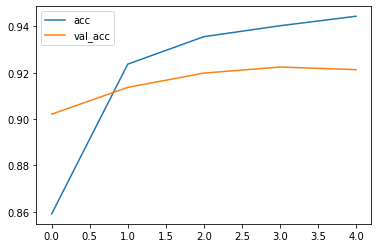

<Figure size 432x288 with 0 Axes>

In [11]:
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()
plt.savefig("Accuracy plot.jpg")

In [12]:
def predict_sentiment(text):
    tw = tokenizer.texts_to_sequences([text])
    tw = pad_sequences(tw,maxlen=200)
    prediction = int(model.predict(tw).round().item())
    print("Kết Quả: ", sentiment_label[1][prediction])

In [13]:
test_sentence1 = input("Nhập cmt:")
predict_sentiment(test_sentence1)

Nhập cmt:Sản phẩm tốt, shop nhiệt tình với khách
Kết Quả:  POS
